In [1]:
# Libraries
#import os.path

import os.path

import numpy as np
import pandas as pd

from datetime import timedelta 
from datetime import datetime

import sklearn

from sklearn.linear_model import LogisticRegression
#from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from category_encoders import TargetEncoder

import shap

from catboost import CatBoostClassifier, Pool
from catboost import *
from hyperopt import fmin, hp, tpe

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
import eli5

#import lime
#import numpy as np
#import pandas as pd
##import seaborn as sns
#import matplotlib.pyplot as plt
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#import warnings
warnings.filterwarnings("ignore")
#from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
np.random.seed(123)


%matplotlib inline

pd.options.display.max_columns = None
pd.options.display.max_rows = None

/home/alexp/anaconda3/envs/test/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/alexp/anaconda3/envs/test/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


### import data

In [3]:
data = pd.read_csv("/home/alexp/dataset.all.13.12.2020.csv", low_memory=False)

In [4]:
data.shape

(3344785, 41)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3344785 entries, 0 to 3344784
Data columns (total 41 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   hand_id                             object 
 1   player_name                         object 
 2   street                              object 
 3   action                              object 
 4   player_bet_size                     float64
 5   total_call_amount                   int64  
 6   total_check_amount                  int64  
 7   total_bet_amount                    int64  
 8   total_raise_amount                  int64  
 9   total_fold_amount                   int64  
 10  street_call_amount                  int64  
 11  street_check_amount                 int64  
 12  street_bet_amount                   int64  
 13  street_raise_amount                 int64  
 14  street_fold_amount                  int64  
 15  player_position                     int64  
 16  

### list of columns

In [6]:
print(data.columns[0:])

Index(['hand_id', 'player_name', 'street', 'action', 'player_bet_size',
       'total_call_amount', 'total_check_amount', 'total_bet_amount',
       'total_raise_amount', 'total_fold_amount', 'street_call_amount',
       'street_check_amount', 'street_bet_amount', 'street_raise_amount',
       'street_fold_amount', 'player_position', 'players_in_pot',
       'after_us_decision_players', 'current_pot_size', 'player_stack_size',
       'percent_deposited_of_current_stack', 'pay_for_continue_play',
       'current_bet', 'board_ace_amount', 'board_king_amount',
       'board_queen_amount', 'board_jack_amount', 'board_10_amount',
       'board_9_amount', 'board_8_amount', 'board_7_amount', 'board_6_amount',
       'board_5_amount', 'board_4_amount', 'board_3_amount', 'board_2_amount',
       'board_spades_amount', 'board_hearts_amount', 'board_diamonds_amount',
       'board_clubs_amount', 'ready_combination'],
      dtype='object')


 #  1. Data analysis

## 1.1.1 Cепарация столбцов и графики дисбаланса классов, важнейших фичей, определение числа сессий

In [7]:
hands = data.loc[:, 'hand_id'].drop_duplicates() # hands = quantity of parssed sessions

In [8]:
hands.shape

(756750,)

In [9]:
print(hands.head())

0     2018-10-26_PS_NL400_SH_6607_hands_192599878130
6     2018-10-26_PS_NL400_SH_6607_hands_192599971694
15    2018-10-26_PS_NL400_SH_6607_hands_192607853440
19    2018-10-26_PS_NL400_SH_6607_hands_192607784927
23    2018-10-26_PS_NL400_SH_6607_hands_192599943462
Name: hand_id, dtype: object


In [10]:
streets = data.loc[:, 'street'].drop_duplicates()
print(streets)

0    PREFLOP
1       FLOP
2       TURN
4      RIVER
Name: street, dtype: object


<AxesSubplot:xlabel='street', ylabel='count'>

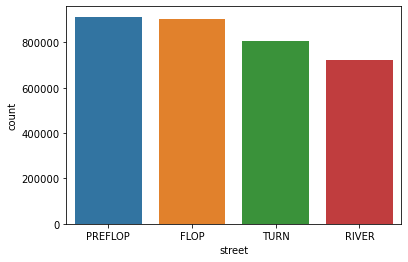

In [11]:
sns.countplot(x = 'street', data=data)

In [12]:
combinations = data.loc[:, 'ready_combination'].drop_duplicates()
print(combinations)

0                   AIR
1              STRAIGHT
7              ONE_PAIR
13             TWO_PAIR
20            HIGH_CARD
79      THREE_OF_A_KIND
184               FLUSH
211          FULL_HOUSE
604      FOUR_OF_A_KIND
1838     STRAIGHT_FLUSH
Name: ready_combination, dtype: object


<AxesSubplot:xlabel='count', ylabel='ready_combination'>

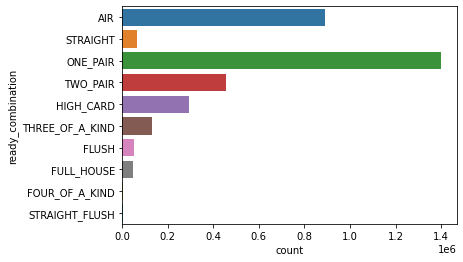

In [13]:
sns.countplot(y = 'ready_combination', data=data)

In [14]:
actions = data.loc[:, 'action'].drop_duplicates()
print(actions)

0        RAISE
1          BET
2        CHECK
3         CALL
93817     FOLD
Name: action, dtype: object


<AxesSubplot:xlabel='action', ylabel='count'>

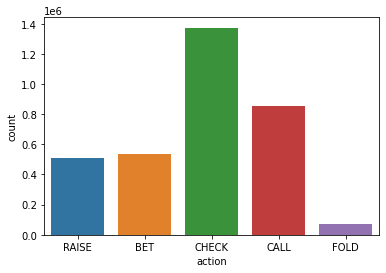

In [15]:
sns.countplot(x = 'action', data=data)

### 1.1.2 Players values

In [16]:
sns.set(rc={'figure.figsize':(11.7, 20)})

<AxesSubplot:xlabel='count', ylabel='player_name'>

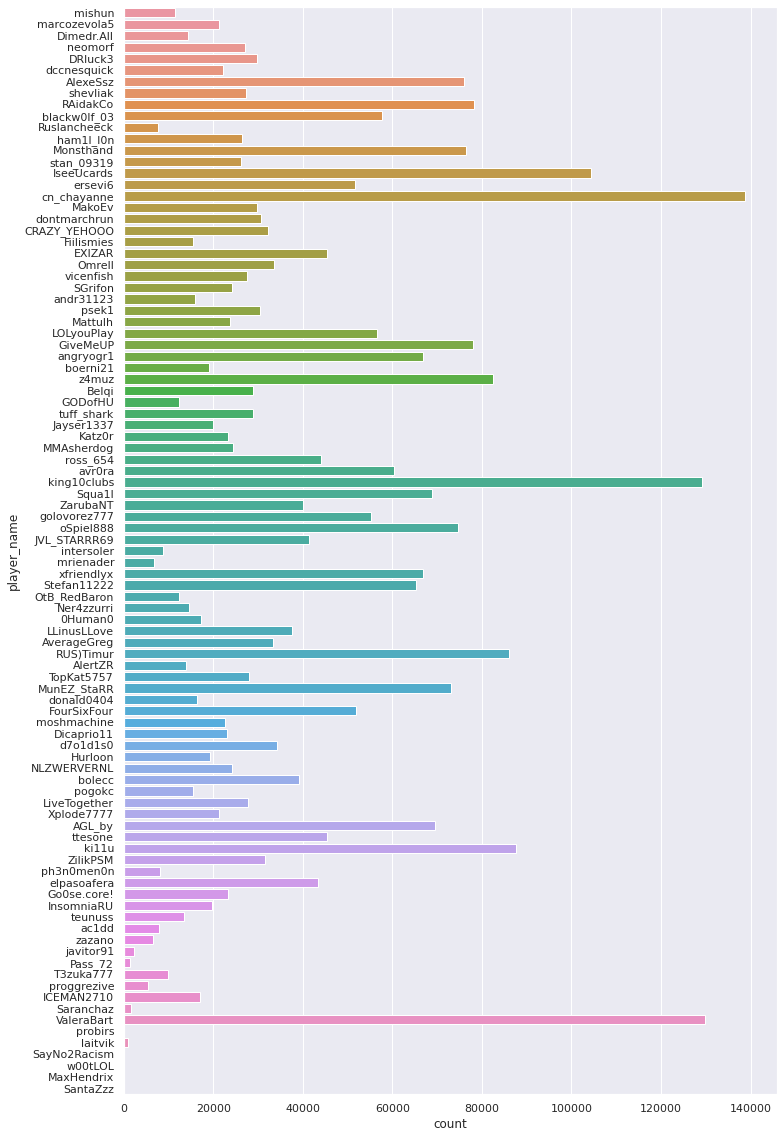

In [17]:
sns.countplot(y = 'player_name', data=data)

In [18]:
'''ОПИСАНИЕ ПЕРЕМЕННЫХ'''
def description(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['PercMissing'] = df.isnull().sum().values / df.isnull().count().values
    summary['Uniques'] = df.nunique().values
   # summary['First Value'] = df.iloc[0].values
   # summary['Second Value'] = df.iloc[1].values
   # summary['Third Value'] = df.iloc[2].values
    return summary
print('**Параметры переменных из DataFrame:**')
description(data)

**Параметры переменных из DataFrame:**
Dataset Shape: (3344785, 41)


,Name,dtypes,Missing,PercMissing,Uniques
0,hand_id,object,0,0.0,756750
1,player_name,object,0,0.0,95
2,street,object,0,0.0,4
3,action,object,0,0.0,5
4,player_bet_size,float64,0,0.0,97416
5,total_call_amount,int64,0,0.0,15
6,total_check_amount,int64,0,0.0,18
7,total_bet_amount,int64,0,0.0,4
8,total_raise_amount,int64,0,0.0,10
9,total_fold_amount,int64,0,0.0,8


In [19]:
data.current_pot_size = data.current_pot_size.astype(int)

In [20]:
data.hand_id = data.hand_id.astype(str)

In [21]:
data.player_stack_size = data.player_stack_size.astype(int)

In [22]:
data.percent_deposited_of_current_stack = data.percent_deposited_of_current_stack.astype(int)

In [23]:
data.pay_for_continue_play = data.pay_for_continue_play.astype(int)

In [24]:
data.current_bet = data.current_bet.astype(int)

In [25]:
description(data)

Dataset Shape: (3344785, 41)


,Name,dtypes,Missing,PercMissing,Uniques
0,hand_id,object,0,0.0,756750
1,player_name,object,0,0.0,95
2,street,object,0,0.0,4
3,action,object,0,0.0,5
4,player_bet_size,float64,0,0.0,97416
5,total_call_amount,int64,0,0.0,15
6,total_check_amount,int64,0,0.0,18
7,total_bet_amount,int64,0,0.0,4
8,total_raise_amount,int64,0,0.0,10
9,total_fold_amount,int64,0,0.0,8


### 1.3 Удалим NaN: в текущем DataFrame у нас таких значений нет.

In [26]:
def replace_nan(data):
    for column in data.columns:
        if data[column].isna().sum() > 0:
            data[column] = data[column].fillna(data[column].mode()[0])


replace_nan(data)

### 1.4 Энкодинг фичей. Все string - параметры будут отброшены методом корелляции corr(), чтобы этого избежать - я присваиваю каждому string - значению число.

In [27]:
ttrain = data

In [28]:
#street
ttrain.street.replace(to_replace = ['PREFLOP', 'FLOP','TURN', 'RIVER'], value = list(range(4)), inplace = True) #
# ready_combination
ttrain.ready_combination.replace(to_replace = ['TWO_PAIR', 'ONE_PAIR', 'HIGH_CARD', 'AIR', 'STRAIGHT', 'THREE_OF_A_KIND', 'FLUSH', 'FULL_HOUSE', 'STRAIGHT_FLUSH', 'FOUR_OF_A_KIND'], value = list(range(10)), inplace = True)
#action
#ttrain.action.replace(to_replace = ['RAISE', 'BET','CHECK', 'CALL', 'FOLD'], value = [0, 1, 2, 3, 2], inplace = True)
ttrain.action.replace(to_replace = ['CHECK'], value = ['FOLD'], inplace = True)


#test.street.replace(to_replace = ['PREFLOP', 'FLOP','TURN', 'RIVER'], value = list(range(4)), inplace = True)
#test.action.replace(to_replace = ['RAISE', 'BET','CHECK', 'CALL', 'FOLD'], value = list(range(5)), inplace = True)

#test.ready_combination.replace(to_replace = ['TWO_PAIR', 'ONE_PAIR', 'HIGH_CARD', 'AIR', 'STRAIGHT', 'THREE_OF_A_KIND', 'FLUSH', 'FULL_HOUSE', 'STRAIGHT_FLUSH', 'FOUR_OF_A_KIND'], value = list(range(10)), inplace = True)


In [29]:
ttrain.head()

,hand_id,player_name,street,action,player_bet_size,total_call_amount,total_check_amount,total_bet_amount,total_raise_amount,total_fold_amount,street_call_amount,street_check_amount,street_bet_amount,street_raise_amount,street_fold_amount,player_position,players_in_pot,after_us_decision_players,current_pot_size,player_stack_size,percent_deposited_of_current_stack,pay_for_continue_play,current_bet,board_ace_amount,board_king_amount,board_queen_amount,board_jack_amount,board_10_amount,board_9_amount,board_8_amount,board_7_amount,board_6_amount,board_5_amount,board_4_amount,board_3_amount,board_2_amount,board_spades_amount,board_hearts_amount,board_diamonds_amount,board_clubs_amount,ready_combination
0,2018-10-26_PS_NL400_SH_6607_hands_192599878130,mishun,0,RAISE,12.00,0,0,0,0,3,0,0,0,0,3,0,0,1,6,572,0,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
1,2018-10-26_PS_NL400_SH_6607_hands_192599878130,mishun,1,BET,13.30,1,0,0,1,3,0,0,0,0,0,0,2,1,26,560,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,2,4
2,2018-10-26_PS_NL400_SH_6607_hands_192599878130,mishun,2,FOLD,0.00,2,0,1,1,3,0,0,0,0,0,0,2,1,52,546,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,2,4
3,2018-10-26_PS_NL400_SH_6607_hands_192599878130,mishun,2,CALL,34.23,2,1,2,1,3,0,1,1,0,0,2,2,1,86,546,0,34,34,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,2,4
4,2018-10-26_PS_NL400_SH_6607_hands_192599878130,mishun,3,FOLD,0.00,3,1,2,1,3,0,0,0,0,0,0,2,1,121,512,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,2,1,0,2,4


In [30]:
ttrain = ttrain.drop(columns=['hand_id', 'player_name'])
ttrain.head(1)

,street,action,player_bet_size,total_call_amount,total_check_amount,total_bet_amount,total_raise_amount,total_fold_amount,street_call_amount,street_check_amount,street_bet_amount,street_raise_amount,street_fold_amount,player_position,players_in_pot,after_us_decision_players,current_pot_size,player_stack_size,percent_deposited_of_current_stack,pay_for_continue_play,current_bet,board_ace_amount,board_king_amount,board_queen_amount,board_jack_amount,board_10_amount,board_9_amount,board_8_amount,board_7_amount,board_6_amount,board_5_amount,board_4_amount,board_3_amount,board_2_amount,board_spades_amount,board_hearts_amount,board_diamonds_amount,board_clubs_amount,ready_combination
0,0,RAISE,12.0,0,0,0,0,3,0,0,0,0,3,0,0,1,6,572,0,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


### 1.5 Корелляция между фичами.

In [31]:
corrs = ttrain.corr().abs().unstack().sort_values(kind="quicksort").reset_index()

In [32]:
corrs = corrs[corrs['level_0'] != corrs['level_1']]

In [33]:
corrs.shape

(1406, 3)

In [34]:
corrs.tail(10)

,level_0,level_1,0
1396,street,total_call_amount,0.734443
1397,total_call_amount,street,0.734443
1398,current_pot_size,pay_for_continue_play,0.741190
1399,pay_for_continue_play,current_pot_size,0.741190
1400,current_bet,current_pot_size,0.749474
1401,current_pot_size,current_bet,0.749474
1402,street,total_check_amount,0.767876
1403,total_check_amount,street,0.767876
1404,pay_for_continue_play,current_bet,0.992695
1405,current_bet,pay_for_continue_play,0.992695


In [35]:
label_encoder = LabelEncoder()
ttrain.iloc[:,0] = label_encoder.fit_transform(ttrain.iloc[:,0]).astype('float64')

In [36]:
corr = ttrain.corr()

<AxesSubplot:>

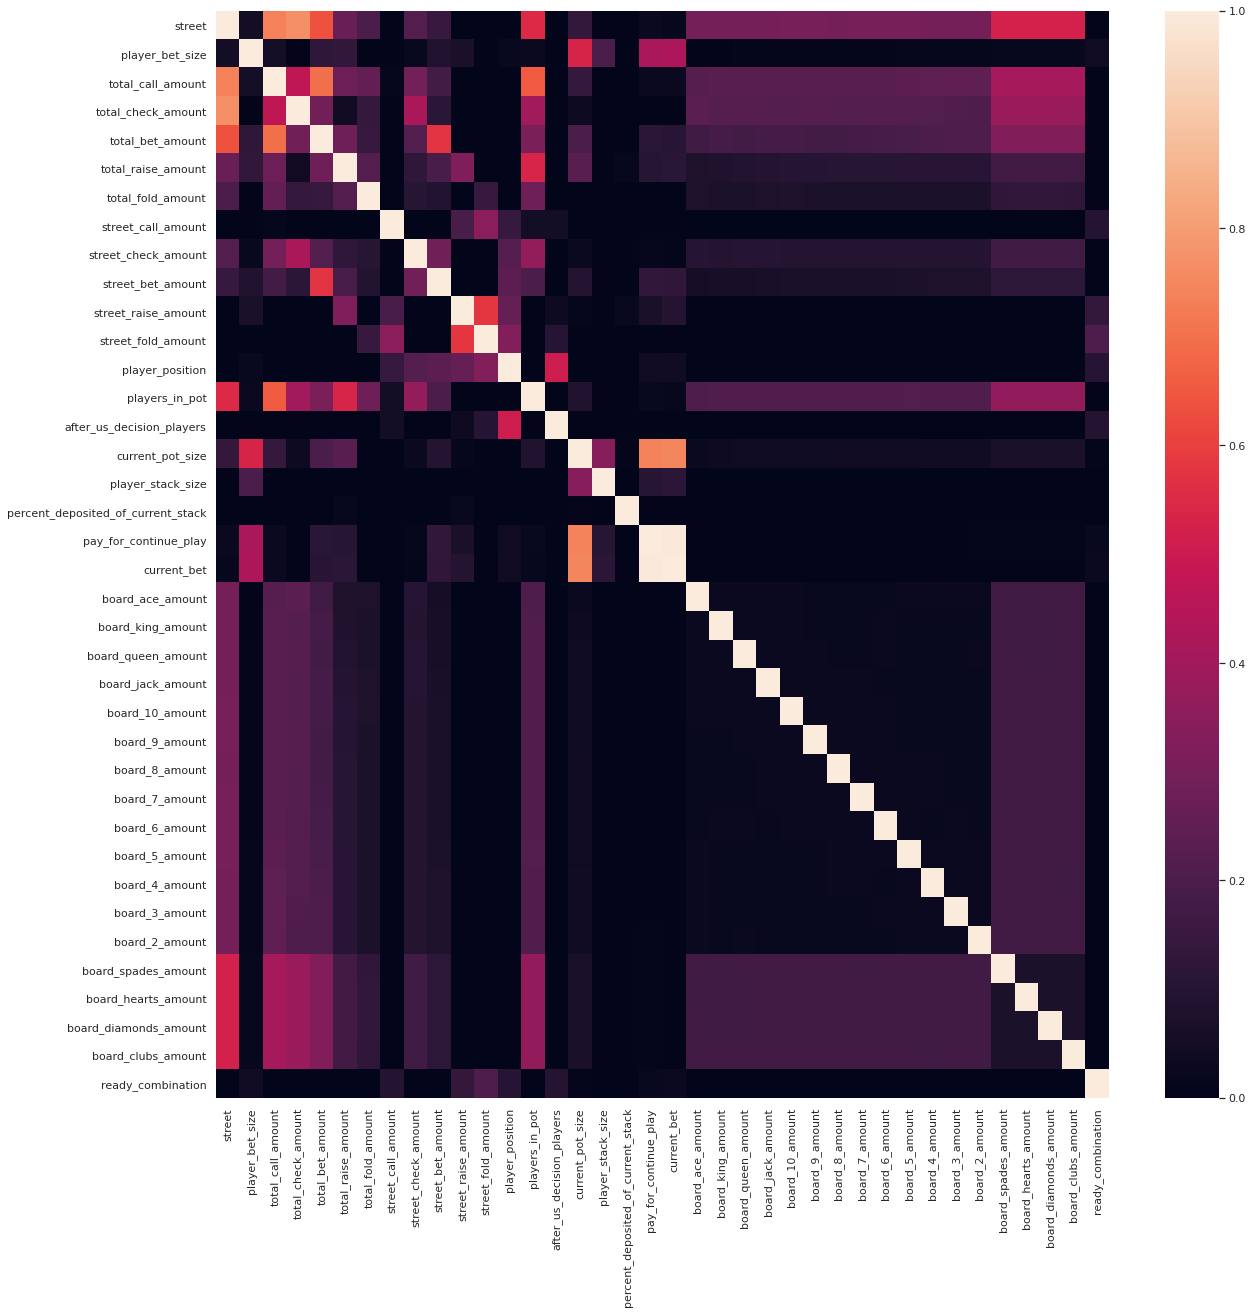

In [37]:
plt.figure(figsize=(20, 20))
sns.heatmap(corr, vmin=0, vmax=1)

### 5.1 Classificator - predict actions

In [38]:
ctarget = data.pop('action')

In [39]:
ctrain = data.drop(columns=['hand_id', 'player_name', 'player_bet_size'])

In [40]:
ctrain.head(1)

,street,total_call_amount,total_check_amount,total_bet_amount,total_raise_amount,total_fold_amount,street_call_amount,street_check_amount,street_bet_amount,street_raise_amount,street_fold_amount,player_position,players_in_pot,after_us_decision_players,current_pot_size,player_stack_size,percent_deposited_of_current_stack,pay_for_continue_play,current_bet,board_ace_amount,board_king_amount,board_queen_amount,board_jack_amount,board_10_amount,board_9_amount,board_8_amount,board_7_amount,board_6_amount,board_5_amount,board_4_amount,board_3_amount,board_2_amount,board_spades_amount,board_hearts_amount,board_diamonds_amount,board_clubs_amount,ready_combination
0,0,0,0,0,0,3,0,0,0,0,3,0,0,1,6,572,0,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


##### split dataset to train & test(validation) data

In [41]:
X_train, X_validation, y_train, y_validation = train_test_split(ctrain, ctarget, random_state=22)

In [42]:
X_train.shape, X_validation.shape, y_train.shape, y_validation.shape

((2508588, 37), (836197, 37), (2508588,), (836197,))

#### params init

In [43]:
best_params = {#'bagging_temperature': 0.5,
               'depth': 5,
               'iterations': 500,
               'l2_leaf_reg': 30,
               'random_strength': 0.8}

#### features

In [44]:
cat_features=['street',  
              'total_call_amount',
              'total_check_amount',
              'total_bet_amount',
              'total_raise_amount',
              'total_fold_amount',
              'street_call_amount',
              'street_check_amount',
              'street_bet_amount',
              'street_raise_amount',
              'street_fold_amount',
              'player_position',
              'players_in_pot',
              'after_us_decision_players',
              'current_pot_size',
              'player_stack_size',
              'percent_deposited_of_current_stack',
              'pay_for_continue_play',
              'current_bet',
              'board_ace_amount',
              'board_king_amount',
              'board_queen_amount',
              'board_jack_amount',
              'board_10_amount',
              'board_9_amount',
              'board_8_amount', 
              'board_7_amount',
              'board_6_amount',
              'board_5_amount', 
              'board_4_amount',
              'board_3_amount',
              'board_2_amount',
              'board_spades_amount', 
              'board_hearts_amount',
              'board_diamonds_amount',
              'board_clubs_amount',
              'ready_combination']

In [45]:
 model_cls = CatBoostClassifier(
        **best_params,
        loss_function='MultiClass',
        #eval_metric='AUC',
        boosting_type = 'Plain',
        bootstrap_type = 'Bernoulli',
        task_type="GPU",
        nan_mode='Min',
        verbose=False,
        cat_features = cat_features
    )

In [46]:
model_cls.fit(
        X_train, y_train,
        verbose_eval=100, 
        early_stopping_rounds=50,
        cat_features=cat_features,
        eval_set=(X_validation, y_validation),
        use_best_model=False,
        plot=True
   )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.3500509	test: 1.3499699	best: 1.3499699 (0)	total: 155ms	remaining: 1m 17s
100:	learn: 0.5609498	test: 0.5609412	best: 0.5609412 (100)	total: 5.59s	remaining: 22.1s
200:	learn: 0.5239296	test: 0.5240415	best: 0.5240415 (200)	total: 10.8s	remaining: 16.1s
300:	learn: 0.5146705	test: 0.5148276	best: 0.5148276 (300)	total: 15.8s	remaining: 10.4s
400:	learn: 0.5097161	test: 0.5099373	best: 0.5099373 (400)	total: 20.7s	remaining: 5.11s
499:	learn: 0.5060774	test: 0.5063631	best: 0.5063631 (499)	total: 25.5s	remaining: 0us
bestTest = 0.5063630714
bestIteration = 499


In [47]:
score = model_cls.score(X_validation, y_validation)
print(score)

0.771001331026062


In [48]:
PATH = "/home/alexp/anaconda3/pokerai-master/models/classifier.13.12.2020.pt"

In [49]:
model_cls.save_model(fname=PATH)

In [50]:
pv = model_cls.predict(X_validation) # pv - predicted values

In [51]:
import json

In [52]:
c = 0
hands = []
for i in range(len(pv)):
    if pv[i] != y_validation.iloc[i]:
        hands.append(data.iloc[i]['hand_id'])
        hands.append(y_validation.iloc[i])
        c += 1
with open('/home/alexp/hands.txt', 'w') as fw:
    json.dump(hands, fw)
print(c)

191488


In [53]:
eli5.show_weights(model_cls, top=50)

Weight,Feature
0.3335,pay_for_continue_play
0.2963,current_bet
0.0509,ready_combination
0.0375,street
0.0344,total_check_amount
0.0330,after_us_decision_players
0.0314,player_position
0.0297,total_raise_amount
0.0283,players_in_pot
0.0167,street_bet_amount


### Regressor - predict player_bet_size

In [54]:
rtarget = data.pop('player_bet_size')

In [57]:
rtrain = data

In [58]:
data.head(3)

,hand_id,player_name,street,total_call_amount,total_check_amount,total_bet_amount,total_raise_amount,total_fold_amount,street_call_amount,street_check_amount,street_bet_amount,street_raise_amount,street_fold_amount,player_position,players_in_pot,after_us_decision_players,current_pot_size,player_stack_size,percent_deposited_of_current_stack,pay_for_continue_play,current_bet,board_ace_amount,board_king_amount,board_queen_amount,board_jack_amount,board_10_amount,board_9_amount,board_8_amount,board_7_amount,board_6_amount,board_5_amount,board_4_amount,board_3_amount,board_2_amount,board_spades_amount,board_hearts_amount,board_diamonds_amount,board_clubs_amount,ready_combination
0,2018-10-26_PS_NL400_SH_6607_hands_192599878130,mishun,0,0,0,0,0,3,0,0,0,0,3,0,0,1,6,572,0,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
1,2018-10-26_PS_NL400_SH_6607_hands_192599878130,mishun,1,1,0,0,1,3,0,0,0,0,0,0,2,1,26,560,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,2,4
2,2018-10-26_PS_NL400_SH_6607_hands_192599878130,mishun,2,2,0,1,1,3,0,0,0,0,0,0,2,1,52,546,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,2,4


In [59]:
##### split dataset to train & test(validation) data

In [ ]:
X_rtrain, X_rvalidation, y_rtrain, y_rvalidation = train_test_split(rtrain, rtarget, random_state=33)


In [ ]:
X_rtrain.shape, X_rvalidation.shape, y_rtrain.shape, y_rvalidation.shape

In [ ]:
model_rgr = CatBoostRegressor(
        **best_params,
        loss_function='RMSE',
        #eval_metric='AUC',
        #boosting_type = 'Plain',
        #bootstrap_type = 'Bernoulli',
        #task_type="GPU",
        nan_mode='Min',
        verbose=False,
        cat_features = cat_features
    )


In [ ]:
model_rgr.fit(
        X_rtrain, y_rtrain,
        verbose_eval=100, 
        early_stopping_rounds=50,
        #cat_features=categorical_features_indices,
        eval_set=(X_rvalidation, y_rvalidation),
        use_best_model=False,
        plot=True
   )

In [ ]:
score = model_rgr.score(X_rvalidation, y_rvalidation)
print(score)

In [ ]:
eli5.show_weights(model_cls, top=50)

In [ ]:
PATH = "/home/alexp/anaconda3/pokerai-master/models/regressor.13.12.2020.pt"

In [ ]:
model_rgr.save_model(fname=PATH)